In [266]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
import datetime as dt
import statsmodels.api as sm
from scipy import stats

In [267]:
os_path = os.getcwd()
energy_df = pd.read_pickle(os_path+'/data/energycons.pkl')

In [268]:
energy_df = energy_df['Load']

In [269]:
#aggregate to daily 
energy_df = energy_df.groupby(energy_df.index.strftime('%Y-%m-%d')).mean()
energy_df.index = pd.to_datetime(energy_df.index)

#limit the data only up to the end of 2020
energy_df = energy_df.loc[energy_df.index<'2021-01-01']
energy_df.head()

2015-01-01    4994.333333
2015-01-02    5249.416667
2015-01-03    5057.916667
2015-01-04    5230.083333
2015-01-05    5596.916667
Name: Load, dtype: float64

# Descriptive statistics for TS

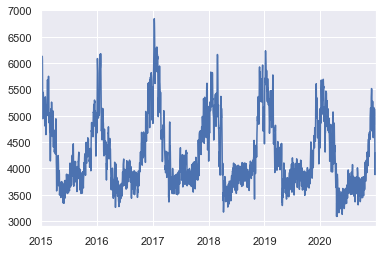

In [270]:
energy_df.plot();

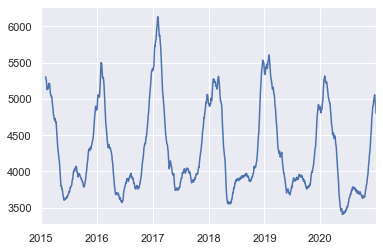

In [8]:
energy_df.rolling(30).mean().plot();

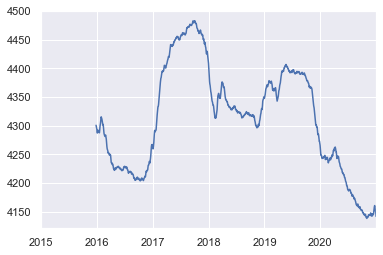

In [10]:
energy_df.rolling(360).mean().plot();

# Distributional properties
TS data is often skewed to the right, especially when the series is a measure of something that can only be positive.

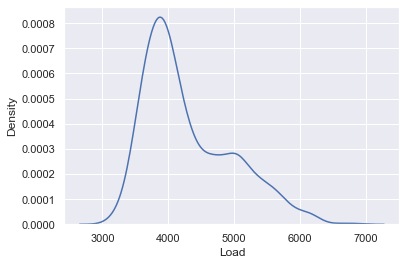

In [11]:
sns.kdeplot(energy_df);

## Possible transformations 

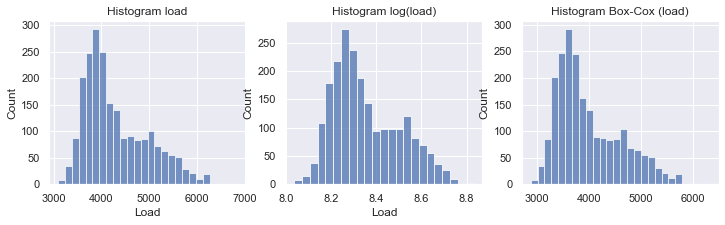

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(energy_df, ax = axes[0]);
axes[0].set_title('Histogram load')

sns.histplot(np.log(energy_df), ax = axes[1]);
axes[1].set_title('Histogram log(load)');

sns.histplot(stats.boxcox(energy_df, lmbda = 0.99), ax = axes[2]);
axes[2].set_title('Histogram Box-Cox (load)');

# Time Series Stationarity

 - Weak vs Strict Stationarity 
 - Weak stationarity implies:
  - 1st moment is constant over time
  - autocovariance is constant over time
  - 2nd moment is finite
 - Strict stationarity implies:
  - the unconditional joint probability distribution does not change over time
  
  Strict stationarity does not imply weak stationarity and vice versa.
  

## Trend vs Difference Stationarity
## Stationarity Tests

 - ADF test: $H_0$ = there is a unit root vs $H_\alpha$ = there isn't; different types of ADF:
  - no constant (drift) or trend in the OLS regression
  - constant (drift) in the OLS regression
  - constant (drift) and linear/quadratic trend
  - http://faculty.smu.edu/tfomby/eco6375/BJ%20Notes/ADF%20Notes.pdf
 - KPSS test:$H_0$ = the series is trend-stationary vs $H_\alpha$ = the series has a unit root

In [79]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(series, crit='BIC'):
    print_tests = 'Stationarity tests \n \
    P-values for: ADF with drift: {0:0.3f}, ADF drift and trend: {1:0.3f}, ADF no drift or trend: {2:0.3f} \n \
    KPSS p-value: {3:0.3f}'
    adftest_c = adfuller(series, autolag='BIC', regression = 'c')
    adftest_ct = adfuller(series, autolag='BIC', regression = 'ct')
    adftest_nc = adfuller(series, autolag='BIC', regression = 'nc')
    kpsstest = kpss(series)

    return print(print_tests.format(adftest_c[1], adftest_ct[1], adftest_nc[1], kpsstest[1]))
    
test_stationarity(energy_df)

Stationarity tests 
     P-values for: ADF with drift: 0.004, ADF drift and trend: 0.021, ADF no drift or trend: 0.578 
     KPSS p-value: 0.100


/Users/geri/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/geri/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


# Autocorrelation and partial autocorrelation functions (ACF and PACF)


### Rule of thumb for 'guessing' lag orders of an ARMA process
|  | ACF | PACF |
| --- | --- | --- |
| AR(p) process| slowly decaying | p lags |
| MA(q) process | q lags | slowly decaying |
| ARMA(p, q) process | slowly decaying | slowly decaying |

In [271]:
def plot_acf_pacf(series, nlags):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sm.graphics.tsa.plot_acf(series, lags=nlags, ax = axes[0])
    axes[0].set_title('Sample ACF')

    sm.graphics.tsa.plot_pacf(series, lags=nlags, ax = axes[1])
    axes[1].set_title('Sample PACF')
    
    return fig

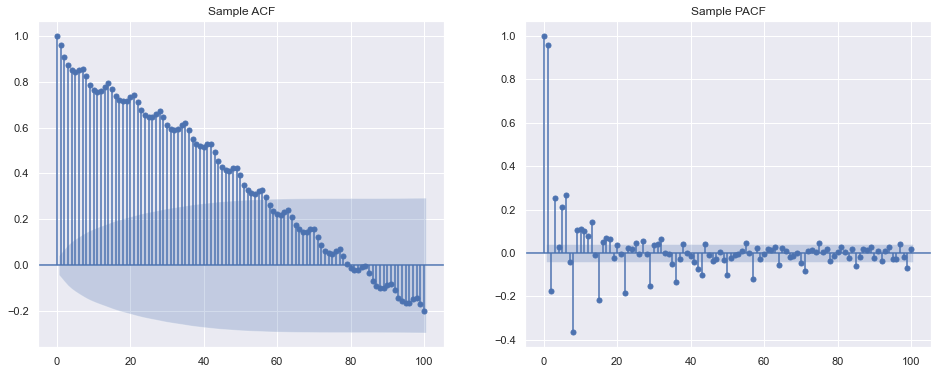

In [272]:
plot_acf_pacf(energy_df, 100);

# Seasonality in TS data

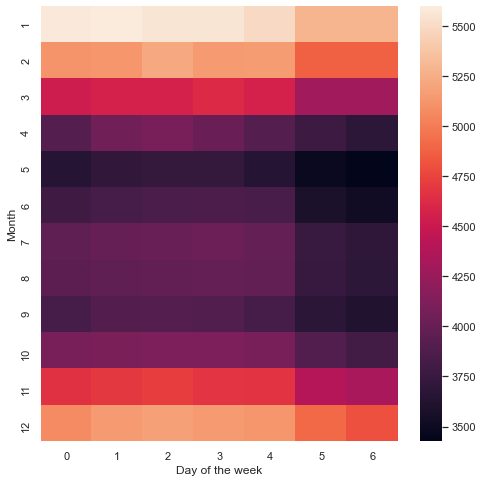

In [35]:
dfnew = pd.DataFrame(energy_df.copy())
dfnew['Month'] = energy_df.index.month
dfnew['Day of the week'] = energy_df.index.weekday

dfnew = pd.pivot_table(dfnew, values='Load', index=['Month'],
                     columns=['Day of the week'], aggfunc=np.mean, fill_value=0)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(dfnew);

# Seasonal Decomposition

## Seasonal Decomposition using moving average
statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
- Additive 
- Multiplicative

## Unobserved components model
https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_seasonal.html

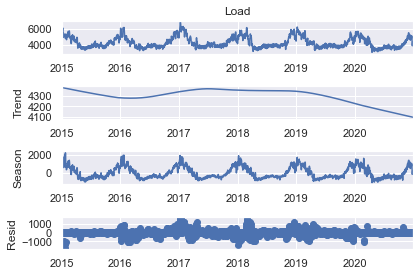

In [317]:
from statsmodels.tsa.seasonal import STL
stl = STL(energy_df, period=365, robust=True)
res_STL = stl.fit()
fig = res_STL.plot()

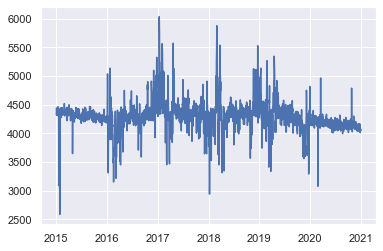

In [318]:
newdf = energy_df - res_STL.seasonal
plt.plot(newdf);

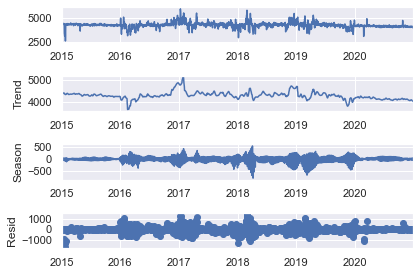

In [319]:
stl = STL(newdf, period=7, robust=True)
res_STL = stl.fit()
fig = res_STL.plot()

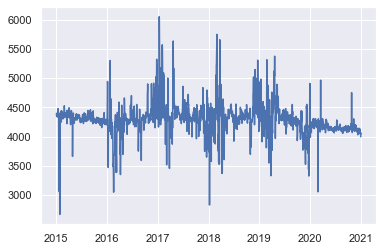

In [320]:
newdf = newdf - res_STL.seasonal
plt.plot(newdf);

In [ ]:
energy_decomp = res

In [321]:
test_stationarity(newdf)

Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.598 
     KPSS p-value: 0.010


/Users/geri/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/geri/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


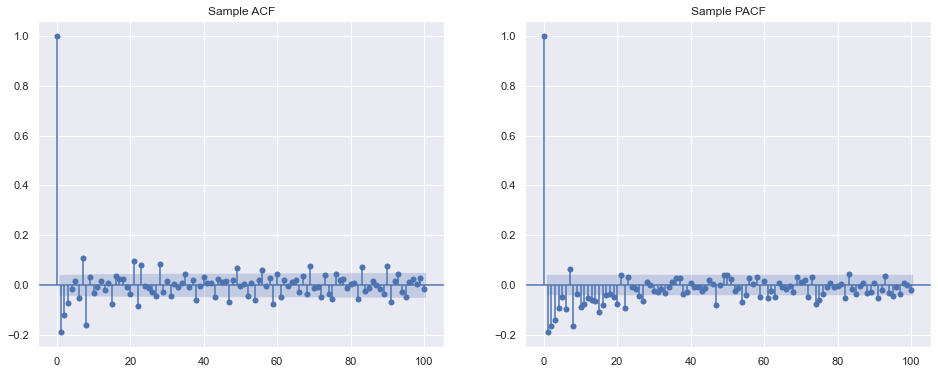

In [323]:
plot_acf_pacf(newdf.diff().dropna(), nlags=100);

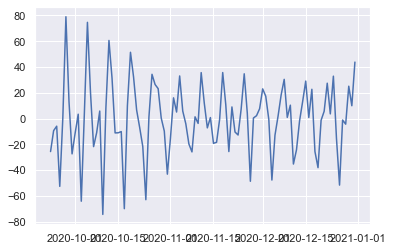

In [326]:
plt.plot(res_STL.seasonal[-100:]);

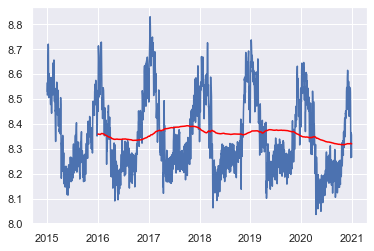

In [66]:
energy_df_ma = energy_df.rolling(365).mean()
#energy_df_ma_std = energy_df.rolling(365).std()

plt.plot(energy_df)
plt.plot(energy_df_ma, color='red');

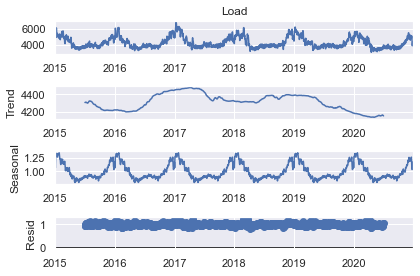

In [281]:
energy_df = energy_df.asfreq('d')
from statsmodels.tsa.seasonal import seasonal_decompose
results_additive = seasonal_decompose(energy_df, model='multiplicative', period = 365)
results_additive.plot();

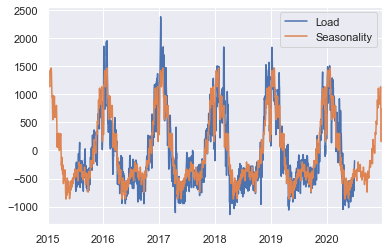

In [109]:
graph = pd.DataFrame(energy_df - energy_df.rolling(365, center=True).mean())
graph['Seasonality'] = results_additive.seasonal
graph.plot();

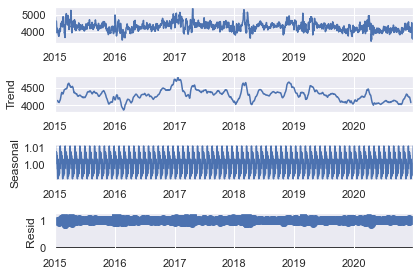

In [288]:
#decomp_df = energy_df/results_additive.seasonal

results_additive_weekly = seasonal_decompose(decomp_df, model='multiplicative', period = 30)
results_additive_weekly.plot();

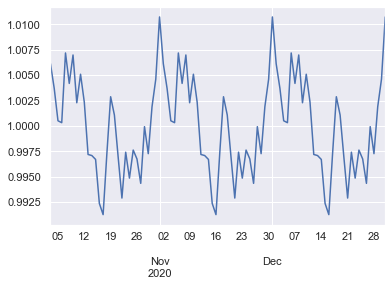

In [291]:
results_additive_weekly.seasonal.iloc[-90:].plot();

In [292]:
decomp_df = decomp_df/results_additive_weekly.seasonal

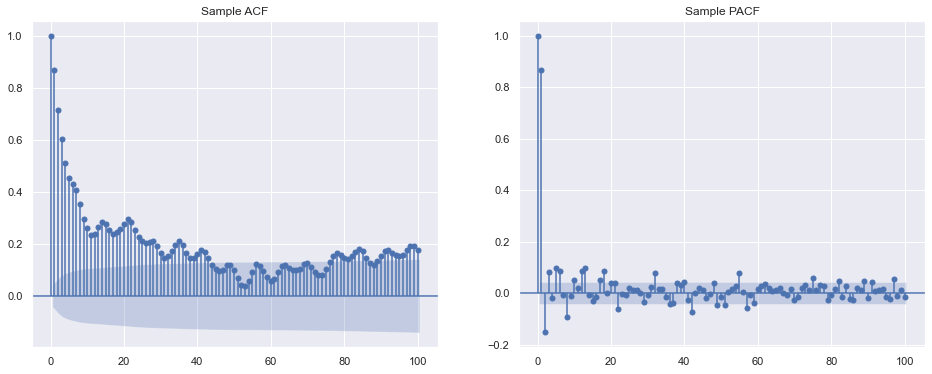

In [294]:
plot_acf_pacf(decomp_df, nlags = 100);

In [295]:
test_stationarity(decomp_df)

Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.526 
     KPSS p-value: 0.010


/Users/geri/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/geri/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


# ARIMA (p, d, q) models 

## Wald's Decomposition
Every weakly stationary, purely nondeterministic, stochastic process $x-\mu$ can be expressed as a linear combination of a sequence of random variables:
$x-\mu = a_t+\psi_1a_{t-1} + ... = \sum_{j = 0}^{\infty}\psi_j a_{t-j}$, where $a_t \sim WN(0, \sigma^2)$


- AR(p) models can be estimated by OLS (efficient estimator)
- ARMA(p, q) models are estimated using MLE, as the MA(q) process is not directly observed in the data
- ARMA can be used only on stationary, invertible and causal stochastic processes
- if the series is I(d), or integrated of order d, we can use the ARIMA(p, d, q) model

## Diagnostics checking
- observing the residuals from the fitted model for misspecifications such as
 - autocorrelated residuals (SACF)
 - overfit the model by including p+1/q+1 lags in order to check if they are significant

## Choosing lags (hyperpar-s) based on information criteria
- AIC: $AIC(p, q) = log\hat{\sigma}^2 + 2(p+q)T^{-1}$
- BIC: $BIC(p, q) = log\hat{\sigma}^2 + (p+q)T^{-1}logT$
- BIC is *strongly consistent*, or in other words chooses the 'true' model asymptotically, whereas AIC will choose an over-parametrized model (might be better for forecasting)

In [42]:
from statsmodels.tsa.ar_model import AutoReg
out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
res = AutoReg(decomp_df.dropna(), lags = 15, seasonal=False).fit()
print(out.format(res.aic, res.hqic, res.bic))

AIC: 9.601, HQIC: 9.617, BIC: 9.645


C:\Users\GerganaMarkova\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [43]:
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2192
Model:                    AutoReg(15)   Log Likelihood              -13522.761
Method:               Conditional MLE   S.D. of innovations            120.628
Date:                Mon, 01 Feb 2021   AIC                              9.601
Time:                        14:33:13   BIC                              9.645
Sample:                    01-16-2015   HQIC                             9.617
                         - 12-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    396.6636     57.463      6.903      0.000     284.037     509.290
y.L1           1.0507      0.021     49.051      0.000       1.009       1.093
y.L2          -0.2527      0.031     -8.130      0.0

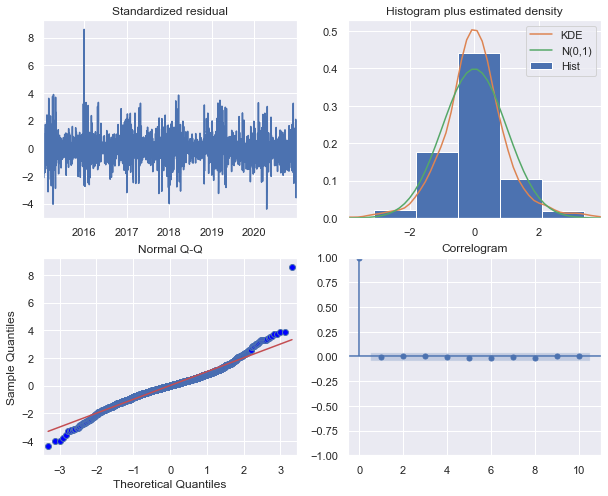

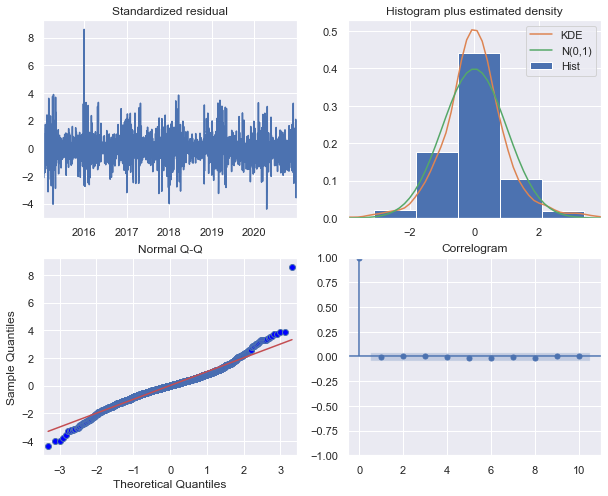

In [44]:
res.plot_diagnostics(figsize = (10, 8))

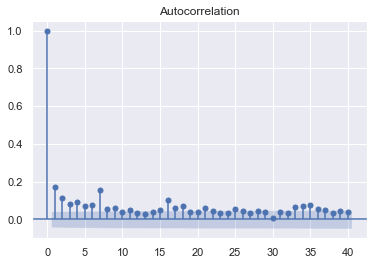

In [45]:
residuals = res.resid

sm.graphics.tsa.plot_acf(residuals**2, lags=40)
plt.show()

# Automized ways of tuning the hyperpar-s

In [119]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

ModuleNotFoundError: No module named 'pmdarima'

In [120]:
from pmdarima.arima import KPSSTest
from pmdarima.arima import ADFTest

adftest = ADFTest(alpha = 0.05)
adftest.should_diff(decomp_df)

ModuleNotFoundError: No module named 'pmdarima'

In [48]:
from pmdarima.arima import ndiffs
ndiffs(decomp_df, test = 'adf')

0

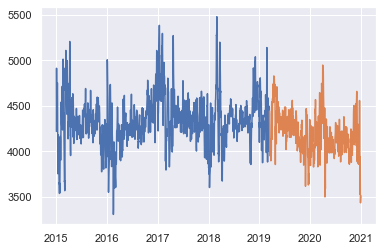

In [50]:
train, test = train_test_split(decomp_df, train_size=int(0.7*len(decomp_df)))
plt.plot(train)
plt.plot(test);

In [75]:
model = pm.auto_arima(train, start_p = 0, start_q = 0, 
                      max_p = 10, max_d = 2, max_q = 20, information_criterion='aic',
                      test = 'kpss', max_P=2, max_D=1, max_Q=3, max_order=5, m=2, seasonal=False)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (2) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2172
Model:               SARIMAX(3, 0, 5)   Log Likelihood              -14145.751
Date:                Mon, 01 Feb 2021   AIC                          28309.503
Time:                        15:19:35   BIC                          28360.653
Sample:                             0   HQIC                         28328.206
                               - 2172                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2410      0.003    730.178      0.000       2.235       2.247
ar.L2         -2.2329      0.005   -421.756      0.000      -2.243      -2.223
ar.L3          0.9919      0.003    348.579      0.000       0.986       0.997
ma.L1         -1.2564      0.020    -62.393      0.000      -1.296      -1.217
ma.L2          0.7813      0.034     23.038      0.000       0.715       0.848
ma.L3          0.3480      0.039      8.862      0.000       0.271       0.425
ma.L4         -0.3729      0.035    -10.684      0.000      -0.441      -0.305
ma.L5          0.1040      0.022      4.689      0.000       0.061       0.147
sigma2      3.083e+04   2.02e-07   1.53e+11      0.000    3.08e+04    3.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.71   Jarque-Bera (JB):               212.61
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.10
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.81e+26. Standard errors may be unstable.
"""

In [67]:
forecast = pd.DataFrame(model.predict(n_periods = len(test)), index = test.index)
forecast.columns = ['Forecast']

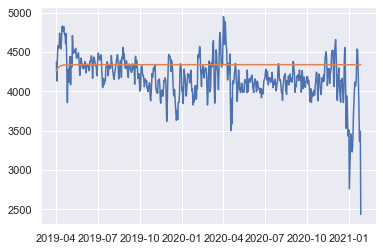

In [68]:
plt.plot(test, label='test')
plt.plot(forecast, label='forecast');

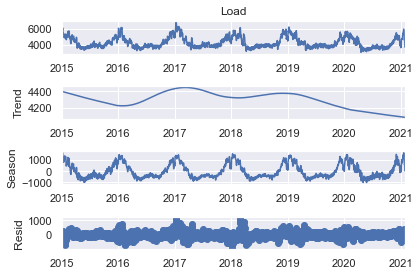

In [96]:
from statsmodels.tsa.seasonal import STL
res = STL(energy_df, period = 365).fit()
res.plot()
plt.show()

<AxesSubplot:>

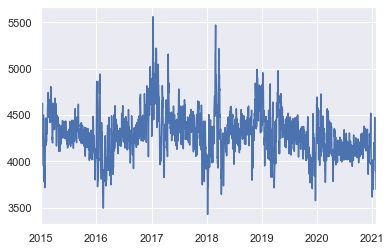

In [97]:
df1 = energy_df - res.seasonal
df1.plot()

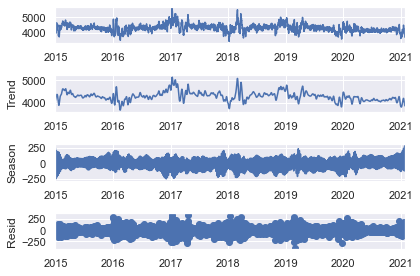

In [98]:
res = STL(df1, period = 7).fit()
res.plot()
plt.show()

In [121]:
df1 = df1- res.seasonal

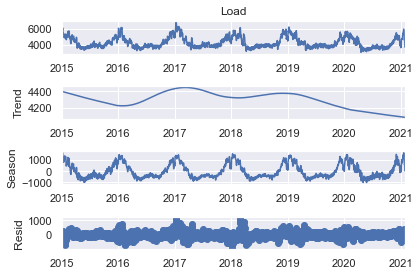

In [99]:
from statsmodels.tsa.seasonal import STL
stl = STL(energy_df, period=365)
res = stl.fit()
fig = res.plot()

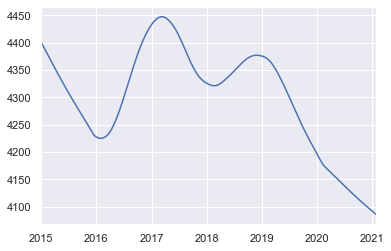

In [100]:
res.trend.plot();

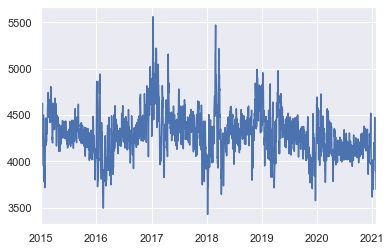

In [101]:
decomp_df1 = energy_df - res.seasonal
decomp_df1.plot();

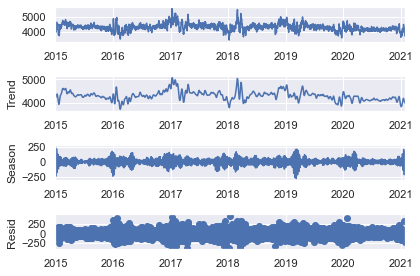

In [102]:
stl = STL(decomp_df1, period=6)
res = stl.fit()
fig = res.plot()

<AxesSubplot:>

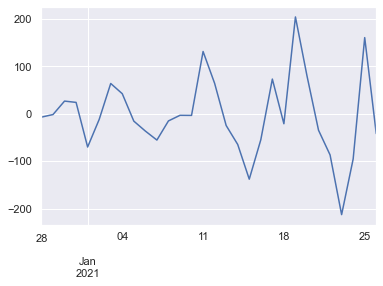

In [104]:
res.seasonal.iloc[-30:].plot()

# Unobserved Components Model

                                 Unobserved Components Results                                 
Dep. Variable:                                       y   No. Observations:                 2192
Model:                          random walk with drift   Log Likelihood              -13780.936
                      + stochastic freq_seasonal(7(3))   AIC                          27567.872
                   + stochastic freq_seasonal(365(16))   BIC                          27584.895
Date:                                 Mon, 01 Feb 2021   HQIC                         27574.099
Time:                                         23:51:02                                         
Sample:                                              0                                         
                                                - 2192                                         
Covariance Type:                                   opg                                         
                                   coef 

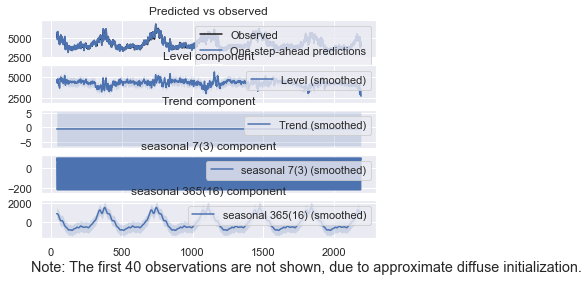

In [226]:
model = sm.tsa.UnobservedComponents(energy_df.values,
                                    level='rwdrift',
                                    freq_seasonal=[{'period': 7,
                                                    'harmonics': 3},
                                                    {'period': 365,
                                                     'harmonics': 16}])
res_f = model.fit(disp=False)
print(res_f.summary())
# The first state variable holds our estimate of the intercept
print("fixed intercept estimated as {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))

res_f.plot_components()
plt.show()

In [230]:
from datetime import datetime
def plot_forecast(series, resultsclass, start_date, end_date, dynamic):
    #get datetime fron the string dates
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    #new index for the foreacast df
    new_index = pd.date_range(start_date_dt, end_date_dt)
    #calculate int indices
    index_start_date = series.index.get_loc(start_date)
    index_end_date = index_start_date + len(new_index)-1
    #get the forecast
    df = resultsclass.get_prediction(index_start_date, index_end_date, dynamic).summary_frame()
    df.index = new_index
    #graph
    plt.figure(figsize=(18, 10))
    plt.plot(df['mean'], color='r');
    plt.plot(series[new_index], color='black')
    plt.fill_between(df.index, df['mean_ci_lower'], df['mean'], alpha = 0.1, color='darkslategrey')
    plt.fill_between(df.index, df['mean_ci_upper'], df['mean'], alpha = 0.1, color='darkslategrey')
    
    return()


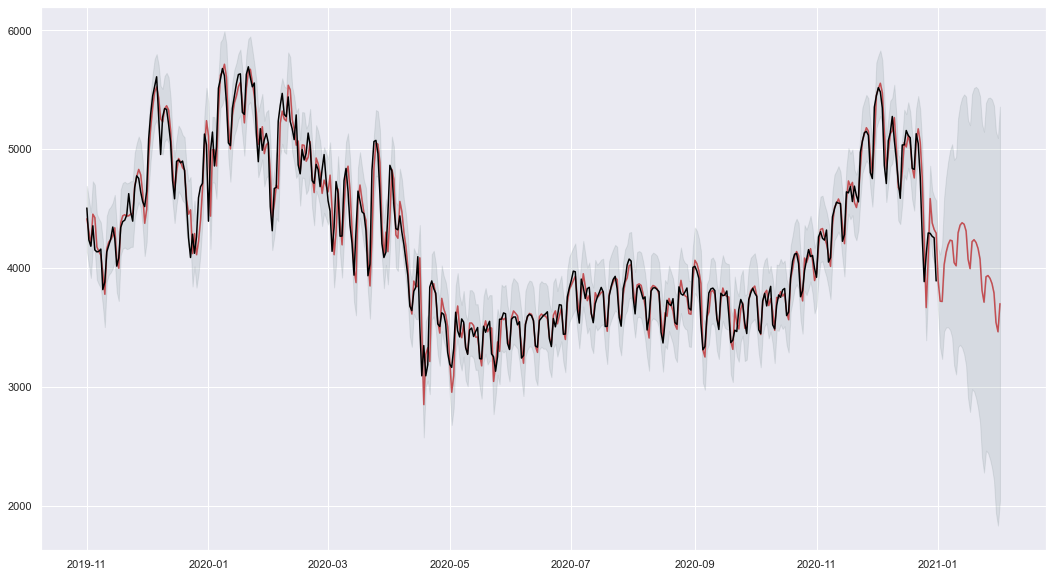

In [239]:
plot_forecast(energy_df, res_f, '2019-11-01', '2021-02-01', False);

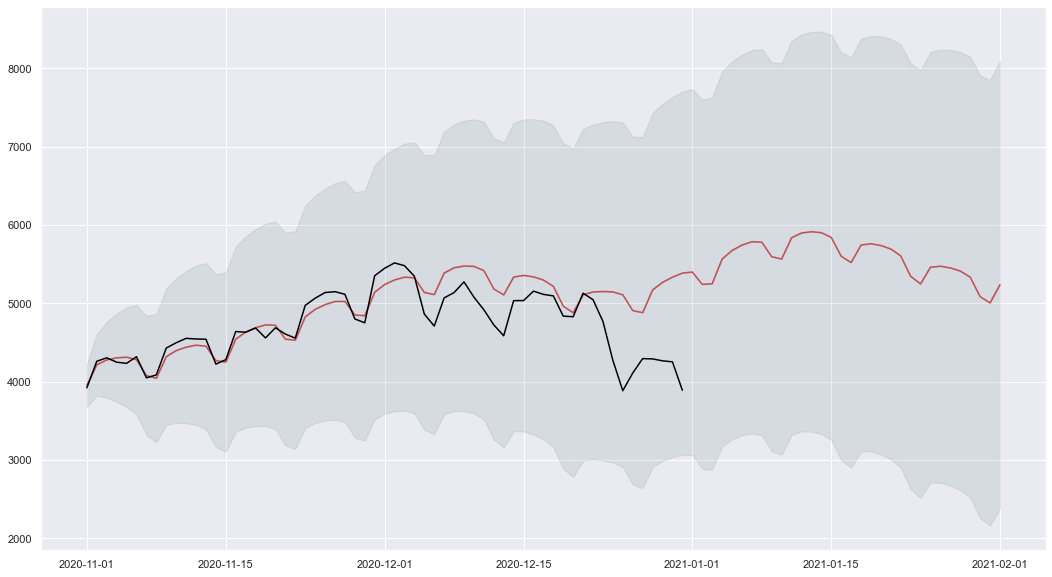

In [236]:
plot_forecast(energy_df, res_f, '2020-11-01', '2021-02-01', True);

# Theta model

In [58]:
from statsmodels.tsa.forecasting.theta import ThetaModel
tm = ThetaModel(energy_df)
res = tm.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                   Load   No. Observations:                 2192
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Mon, 01 Feb 2021   Deseas. Method:         Multiplicative
Time:                        14:43:41   Period:                              7
Sample:                    01-01-2015                                         
                         - 12-31-2020                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    -0.09973647707028607
alpha   0.9998483391886756
--------------------------


# Smoothing

C:\Users\GerganaMarkova\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\GerganaMarkova\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\GerganaMarkova\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


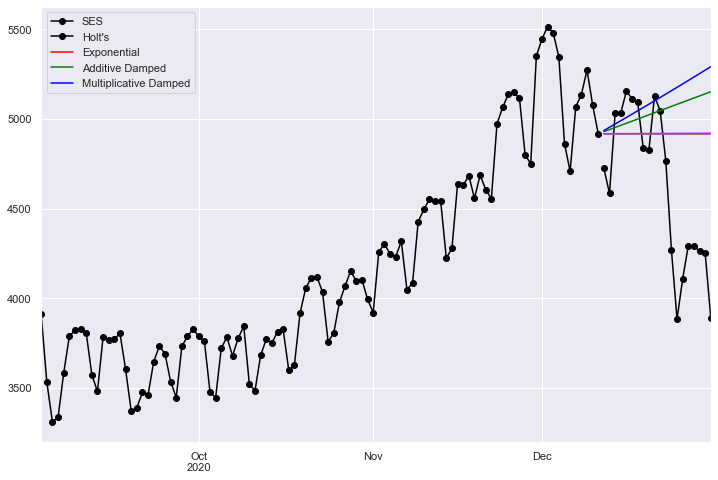

In [61]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

train, test = train_test_split(energy_df, train_size=(len(energy_df)-20))


fit1 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast1 = fit1.forecast(20).rename("SES")
fit2 = Holt(train, initialization_method="estimated").fit()
fcast2 = fit2.forecast(20).rename("Holt's")
fit3 = Holt(train, exponential=True, initialization_method="estimated").fit()
fcast3 = fit3.forecast(20).rename("Exponential")
fit4 = Holt(train, damped_trend=True, initialization_method="estimated").fit(damping_trend=0.98)
fcast4 = fit4.forecast(20).rename("Additive Damped")
fit5 = Holt(train, exponential=True, damped_trend=True, initialization_method="estimated").fit()
fcast5 = fit5.forecast(20).rename("Multiplicative Damped")

ax = train[-100:].plot(color="black", marker="o", figsize=(12,8))
test.plot(ax=ax, color="black", marker="o", legend=False)
fcast1.plot(ax=ax, color='red', legend=True)
fcast2.plot(ax=ax, color='green', legend=True)
fcast3.plot(ax=ax, color='blue', legend=True)
fcast4.plot(ax=ax, color='cyan', legend=True)
fcast5.plot(ax=ax, color='magenta', legend=True)
#ax.set_ylabel('Livestock, sheep in Asia (millions)')
plt.show()
#print('Figure 7.5: Forecasting livestock, sheep in Asia: comparing forecasting performance of non-seasonal methods.')